# Setup

In [11]:
import tensorflow as tf
from tensorflow.python.client import device_lib
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print('='*30)
print(device_lib.list_local_devices())

Num GPUs Available:  1
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 547988087951725044
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 2241331200
locality {
  bus_id: 1
  links {
  }
}
incarnation: 5106390140728889622
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5"
xla_global_id: 416903419
]


In [3]:
import os, re
import numpy as np
import scipy as sp
import pandas as pd
pd.set_option('display.max_columns', None)

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
# import seaborn as sns

from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, BatchNormalization, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import RMSprop, Adam, SGD, Nadam
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Filter unnecessary warnings
import warnings
warnings.filterwarnings("ignore")

***This is an Image classification exercise. We will play with an expired Kaggle competition, please follow the rule of Kaggle and check the following page for more information https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition/overview. After submit you results, use screenshot to show you score (see image below).***


### unzip files

In [ ]:
import zipfile

# Unzip the archive
train_zip = 'G:/My Drive/Fall Semester/msba6421_Predictive Analytics/homework/predictive_hw4/train.zip'
test_zip = 'G:/My Drive/Fall Semester/msba6421_Predictive Analytics/homework/predictive_hw4/test.zip'

with zipfile.ZipFile(train_zip, 'r') as z:
    z.extractall()

with zipfile.ZipFile(test_zip, 'r') as z:
    z.extractall()
    z.close()

### Setup path and directories

In [4]:
# Local directory
TRAIN_DIR = 'G:/My Drive/Fall Semester/msba6421_Predictive Analytics/homework/predictive_hw4/data/train/'
TEST_DIR = 'G:/My Drive/Fall Semester/msba6421_Predictive Analytics/homework/predictive_hw4/data/test/'

# Setup some variables
WIDTH = 160  # use multiples of 16 to minimize padding
HEIGHT = 160
CHANNELS = 3
BATCH_SIZE = 20

train_images = [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR) if i.endswith('.jpg')]
test_images =  [TEST_DIR+i for i in os.listdir(TEST_DIR) if i.endswith('.jpg')]

print('total training images :', len(train_images))
print('total testing images :', len(test_images))

total training images : 25000
total testing images : 12500


In [5]:
# Helper function to sort the image files based on the numeric value in each file name.
def atoi(text):
    return int(text) if text.isdigit() else text

def natural_keys(text):
    return [ atoi(c) for c in re.split('(\d+)', text) ]


# sort the images
train_images.sort(key=natural_keys)
test_images.sort(key=natural_keys)

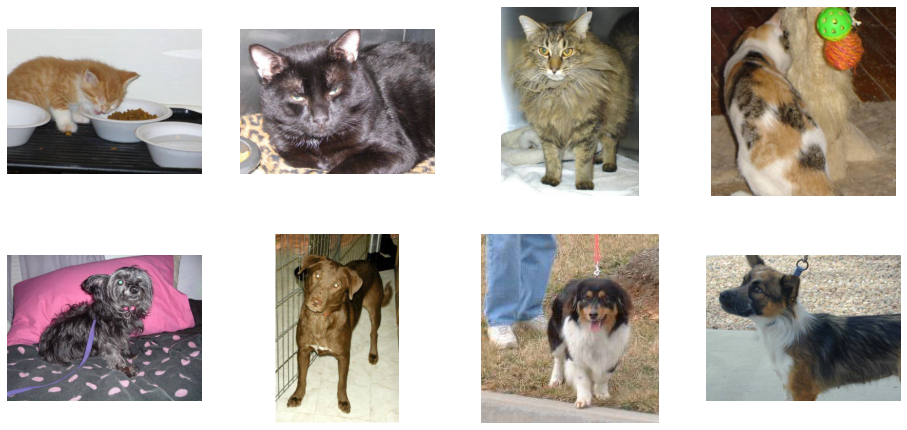

In [ ]:
# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

pic_index = 12504 # Index for iterating over images

# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)


next_pix = train_images[pic_index-8:pic_index] 

for i, img_path in enumerate(next_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

In [6]:
y = []
for i in train_images:
        if 'dog' in i:
            y.append('1')
        elif 'cat' in i:
            y.append('0')


train_df=pd.DataFrame({
    'filename':train_images,
    'class':y
})

test_df = pd.DataFrame({'filename':test_images})

# Train test split the training dataframe
train, validate = train_test_split(train_df, test_size=0.2, stratify=train_df['class'], random_state=seed)

train_df

,filename,class
0,G:/My Drive/Fall Semester/msba6421_Predictive ...,0
1,G:/My Drive/Fall Semester/msba6421_Predictive ...,0
2,G:/My Drive/Fall Semester/msba6421_Predictive ...,0
3,G:/My Drive/Fall Semester/msba6421_Predictive ...,0
4,G:/My Drive/Fall Semester/msba6421_Predictive ...,0
...,...,...
24995,G:/My Drive/Fall Semester/msba6421_Predictive ...,1
24996,G:/My Drive/Fall Semester/msba6421_Predictive ...,1
24997,G:/My Drive/Fall Semester/msba6421_Predictive ...,1
24998,G:/My Drive/Fall Semester/msba6421_Predictive ...,1


<AxesSubplot:xlabel='class', ylabel='count'>

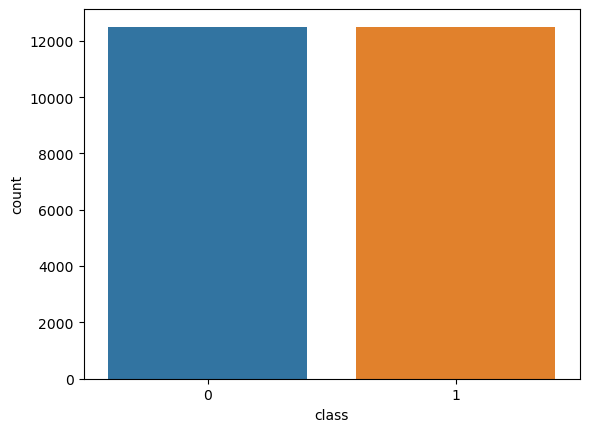

In [ ]:
sns.countplot(x=df['class'])

## Model Building

### Transfer Learning Using `Keras.Application`

In [7]:
base_model = tf.keras.applications.EfficientNetV2B3(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(HEIGHT, WIDTH, CHANNELS),
    include_top=False,  # Do not include the ImageNet classifier at the top.
)  

# Freeze the base model
base_model.trainable = False
# Create new model on top
inputs = tf.keras.Input(shape=(HEIGHT, WIDTH, CHANNELS))
# We make sure that the base_model is running in inference mode here,
# by passing `training=False`. This is important for fine-tuning, as you will
# learn in a few paragraphs.
x = base_model(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dense(512)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation('relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
# A Dense classifier with a single unit (binary classification)
outputs = tf.keras.layers.Dense(1)(x)
model = tf.keras.Model(inputs, outputs)

model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),  # To specify the binary classification, no need to use sigmoid activation function
              optimizer=Nadam(learning_rate=1e-3),
              metrics=[tf.keras.metrics.BinaryAccuracy(threshold=.5)])

# Model Summary
model.summary()

52606240/52606240 [==============================] - 5s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 efficientnetv2-b3 (Function  (None, 5, 5, 1536)       12930622  
 al)                                                             
                                                                 
 global_average_pooling2d (G  (None, 1536)             0         
 lobalAveragePooling2D)                                          
                                                                 
 batch_normalization (BatchN  (None, 1536)             6144      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 512)               786944 

### Image Augmentation

In [8]:
train_datagen = ImageDataGenerator(
    # rescale=1. / 255,  # Using EfficientNet(s) from tf.keras.applications have a rescaling layer built-in as the first layer (you don't need to rescale)
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
)

# Note that the validation data should not be augmented!
validation_datagen = ImageDataGenerator(
    # rescale=1. / 255,
    fill_mode='nearest',
)

train_generator = train_datagen.flow_from_dataframe(
                                        dataframe=train,
                                        directory=None,
                                        target_size=(HEIGHT, WIDTH),
                                        batch_size=BATCH_SIZE,
                                        class_mode="binary",
                                        seed=seed,
                                        shuffle=True,
                                        )

validation_generator = validation_datagen.flow_from_dataframe(
                                        dataframe=validate,
                                        directory=None,
                                        target_size=(HEIGHT, WIDTH),
                                        batch_size=BATCH_SIZE,
                                        class_mode="binary",
                                        seed=seed,
                                        shuffle=True,
                                        )

Found 20000 validated image filenames belonging to 2 classes.
Found 5000 validated image filenames belonging to 2 classes.


### Training

In [9]:
epochs=30
model_path = '/content/drive/My Drive/Fall Semester/msba6421_Predictive Analytics/homework/predictive_hw4/cat_dog_efnV2B3.h5'

# Define callbacks metric
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, mode='min', verbose=1),
    ReduceLROnPlateau(monitor='val_loss', mode='min', patience=2, factor= 0.5, min_lr= 1e-6, verbose=1),
    ModelCheckpoint(model_path, 
                    verbose=1, 
                    monitor='val_loss', 
                    save_best_only=True,
                    mode='min')  # save traning progress
]

# Train the model
history = model.fit(
    train_generator, 
    steps_per_epoch=train_generator.samples//BATCH_SIZE,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples//BATCH_SIZE,
    epochs=epochs,
    callbacks=callbacks,
)

Epoch 1/30
  22/1000 [..............................] - ETA: 1:39:17 - loss: 0.1976 - binary_accuracy: 0.9182

KeyboardInterrupt: 

Text(0.5, 0.98, 'Training Report')

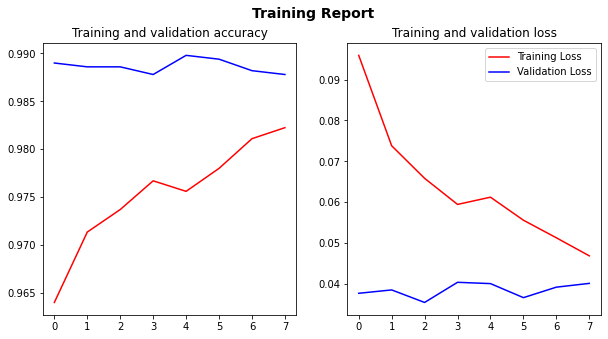

In [11]:
# Plot the model results
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()
plt.suptitle('Training Report', fontsize=14, fontweight='bold')

### Do a round of fine-tuning of the entire model

In [6]:
model_path = 'cat_dog_efnV2B3.h5'
model = tf.keras.models.load_model(model_path, compile=False)

In [7]:
# Make sure to unfreeze the base model
model.layers[1].trainable = True

for layer in model.layers:
    print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x000001F6256AFB80> True
<keras.engine.functional.Functional object at 0x000001F652A14580> True
<keras.layers.pooling.global_average_pooling2d.GlobalAveragePooling2D object at 0x000001F6256AD720> True
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x000001F652F714B0> True
<keras.layers.core.dense.Dense object at 0x000001F61A6BA1D0> True
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x000001F6CAF80310> True
<keras.layers.core.activation.Activation object at 0x000001F6CAF815A0> True
<keras.layers.regularization.dropout.Dropout object at 0x000001F6CAF804F0> True
<keras.layers.core.dense.Dense object at 0x000001F6CAF80D90> True


In [8]:
model.compile(
    optimizer=Nadam(learning_rate=1e-5),  # Low learning rate
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.BinaryAccuracy(threshold=.5)],
)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 efficientnetv2-b3 (Function  (None, 5, 5, 1536)       12930622  
 al)                                                             
                                                                 
 global_average_pooling2d (G  (None, 1536)             0         
 lobalAveragePooling2D)                                          
                                                                 
 batch_normalization (BatchN  (None, 1536)             6144      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 512)               786944    
                                                             

In [12]:
epochs = 3

# Define callbacks metric
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, mode='min', verbose=1),
    ReduceLROnPlateau(monitor='val_loss', mode='min', patience=2, factor= 0.5, min_lr= 1e-6, verbose=1),
    ModelCheckpoint(model_path, 
                    monitor='val_loss', 
                    mode='min',
                    save_best_only=True,
                    verbose=1)  # save traning progress
]

# Train the model
history = model.fit(
    train_generator, 
    steps_per_epoch=train_generator.samples//BATCH_SIZE,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples//BATCH_SIZE,
    epochs=epochs,
    callbacks=callbacks,
)

Epoch 1/3


: 

: 

In [1]:
# Plot the model results
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()
plt.suptitle('Training Report', fontsize=14, fontweight='bold')

NameError: ignored

### Evaluation

In [11]:
# Reload the best model and do the prediction
model_path = 'cat_dog_efnV2B3.h5'
model = tf.keras.models.load_model(model_path, compile=True)

In [12]:
test_datagen = ImageDataGenerator(
    # rescale=1./255
)

test_generator = test_datagen.flow_from_dataframe(test_df,
                                                  target_size=(HEIGHT, WIDTH),
                                                  batch_size=1,
                                                  class_mode=None,
                                                  shuffle=False
)

Found 12500 validated image filenames.


In [13]:
test_pred_proba = model.predict(test_generator,
                                steps=test_generator.samples,
                                verbose=1)

# Because we didn't use sigmoid directly in the last layer (we use from_logits=True for loss function),
# we need to use sigmoid function to get the probability
pred_prob = tf.nn.sigmoid(test_pred_proba).numpy().ravel()

submission = pd.DataFrame({'id': range(1, len(test_images) + 1), 'label':pred_prob})

12500/12500 [==============================] - 5467s 437ms/step


In [14]:
# submission_path = '/content/drive/My Drive/Fall Semester/msba6421_Predictive Analytics/homework/predictive_hw4/submission.csv'
submission_path = 'submission.csv'
submission.to_csv(submission_path, index = False)

### Result and Summary

(-0.5, 1851.5, 800.5, -0.5)

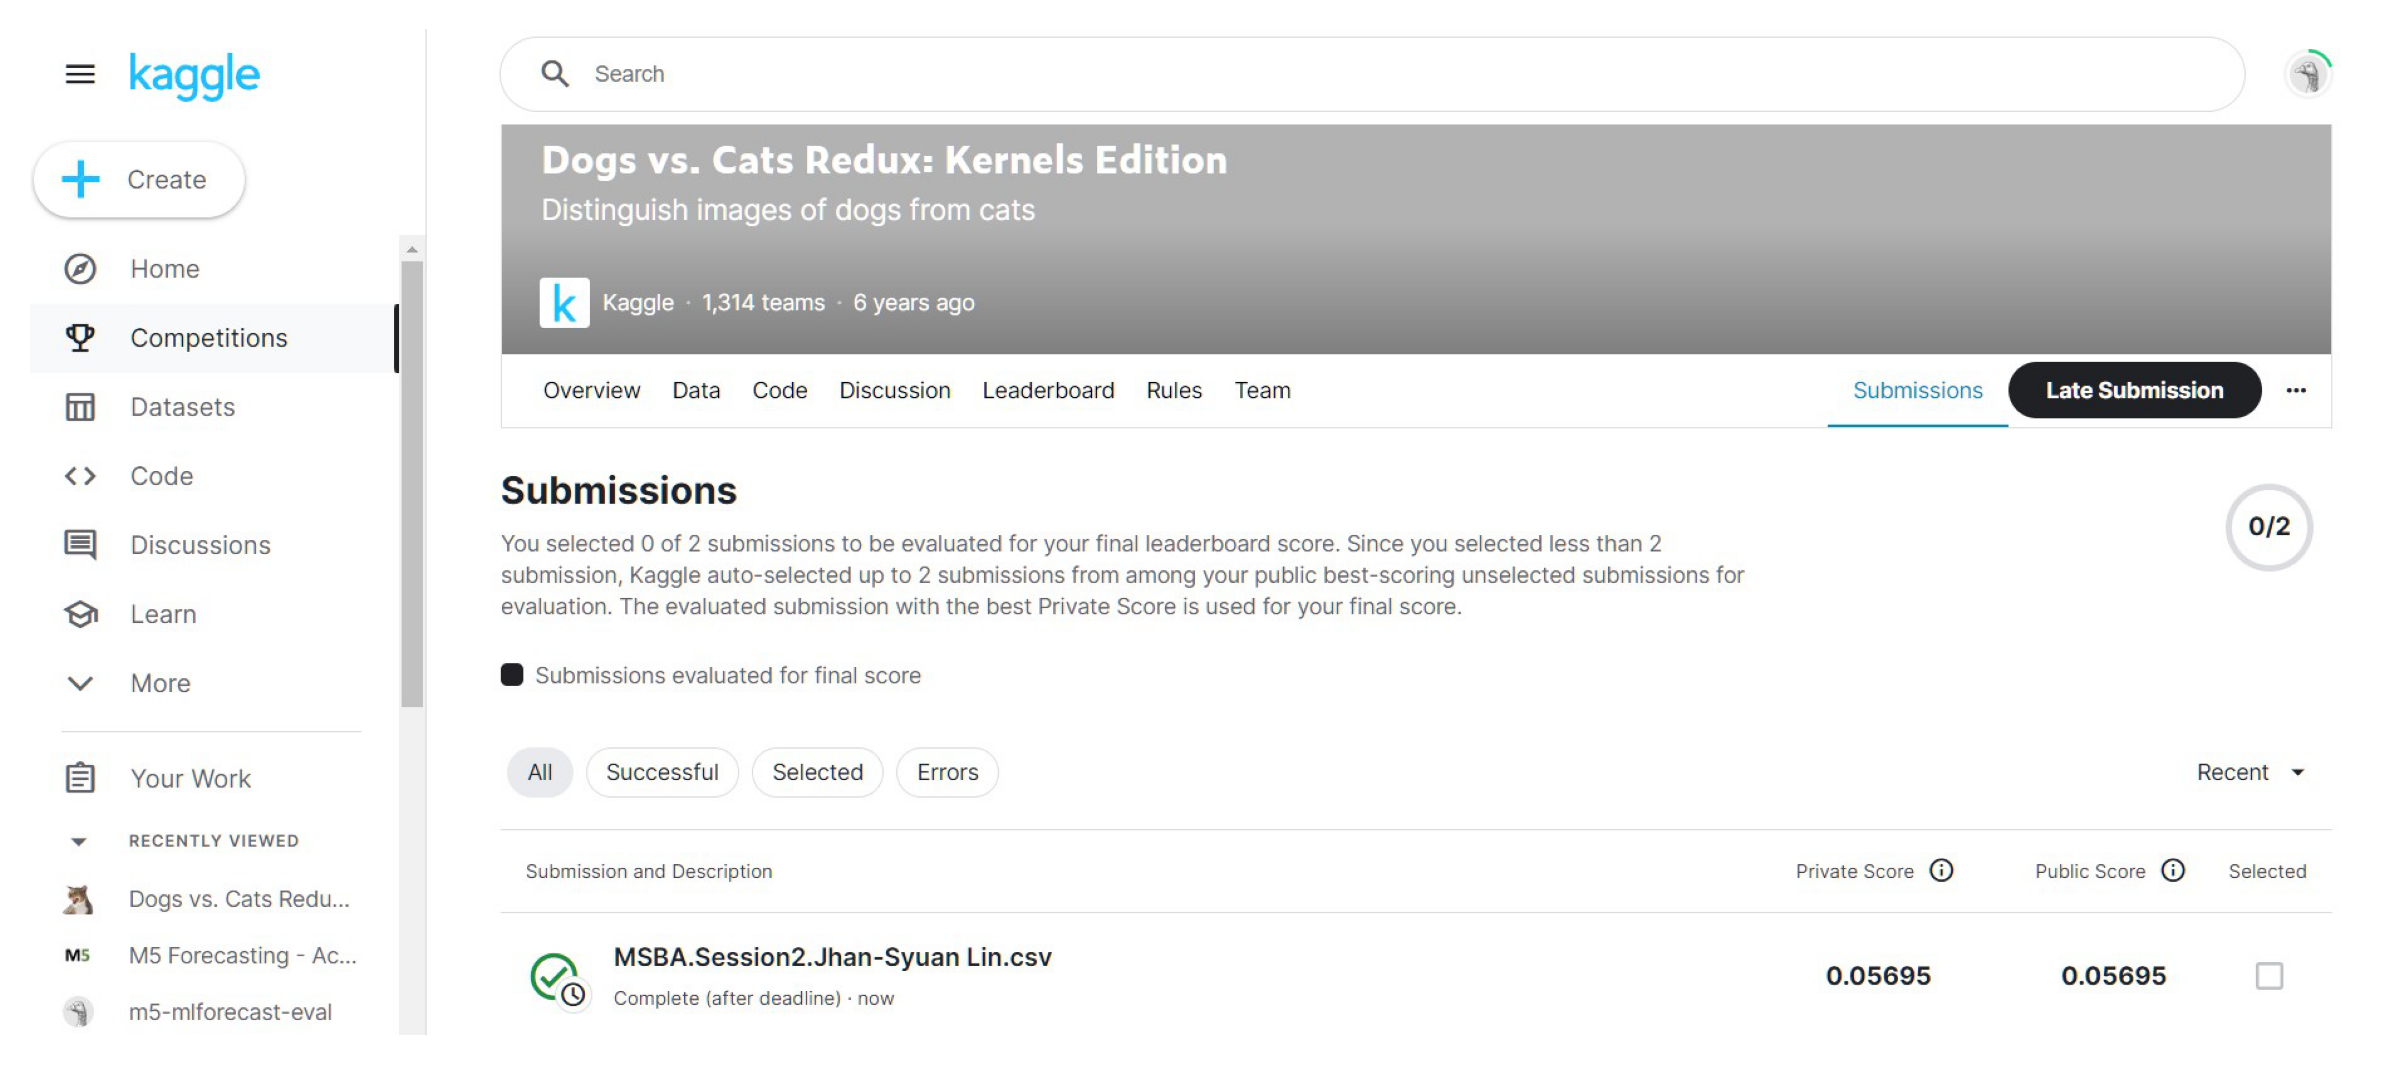

In [9]:
image_path = 'G:/My Drive/Fall Semester/msba6421_Predictive Analytics/homework/predictive_hw4/kaggle_score.jpg'

plt.figure(figsize=(10,10), dpi=300)

img = mpimg.imread(image_path)
plt.imshow(img)
plt.axis('off')

In this project, I utilized the transfer learning technique to build a CNN model for classifying images of dogs and cats. I tried several models, including ResNet, Inception and EfficientNet model, and found out that EfficientNet seems to outperform others on this data. Aside from the transfer learning, I also leverage image augmentation to increase the number and the variety of training images, which helps the model to generalize better. The model was trained on 20000 images of dogs and cats, validated on the rest of the 5000 pictures, and ultimately achieved over 99% accuracy on the validation set. 